# **Training DefenseGAN on the CIFAR-10 Dataset**

* CS486: Robust Machine Learning 
* Drexel University - Spring 2023 
* Luke Ingram

In [3]:
import os 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as vt
from torchvision import datasets
from torchvision.utils import save_image
import torch.autograd as autograd


from models import Generator, Discriminator 


## **Loss Functions**

As the GAN referenced in the [paper](https://arxiv.org/abs/1805.06605) is a WGAN, or Wasserstien-GAN, but we will will be using a WGAN-GP, or *with gradient penalty*, so need to first implement the gradient penalty.

In [4]:
def calc_gradient_penalty(
        discriminator: nn.Module, 
        real_samples: torch.Tensor, 
        fake_samples: torch.Tensor, 
        device: torch.device, 
        lambda_gp: int = 10,
    ) -> torch.Tensor:

    """
    TODO DOCSTRING
    """

    batch_size = real_samples.size(0)

    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    # Get random interpolation between real and fake samples
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates = interpolates.to(device).requires_grad_(True)

    d_interpolates = discriminator(interpolates)

    # Create the 'fake' tensor required for autograd.grad
    fake = torch.ones(d_interpolates.size(), requires_grad=False, device=device)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Flatten the gradients to compute the norm per sample
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


## **Load & Preprocess Data** 

In [5]:
# Hyperparams
BATCH_SIZE = 128
NUM_CLASSES = 10
DEVICE = torch.device('mps')
SAVES_PATH = os.path.join('models', 'checkpoints', 'gans')
DEBUG_PATH = os.path.join('debug_imgs')

In [6]:
mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

transforms = vt.Compose([
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

# Fetch & Create train, validation, and testing datasets

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)

train_loader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)


test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


## **Training & Evaluation Routines**

In [7]:
# Hyperparams 
EPOCHS = 500
LAMBDA_GP = 10 
CRITIC_ITERS = 5 
DISPLAY_STEP = 10 # determines how many epochs to wait before saving output for visual inspection
SAVE_STEP = 100
LATENT_LEN = 100 # Length of latent code for generator 
LEARNING_RATE = 1e-4
DEBUG_VECTOR = torch.randn(BATCH_SIZE, LATENT_LEN).to(DEVICE) # constant input for visual debugging of the generator

In [8]:
def adjust_lr(optimizer, epoch, init_lr = 1e-4, epochs = 200000):
    ''' Linear Learning rate Scheduler '''

    gradient = (float(-init_lr) / epochs)
    
    lr = gradient * epoch + init_lr 

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_gan(generator: nn.Module, discriminator: nn.Module, save_name:str, start_epoch: int): 
    
    optim_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
    optim_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

    grad_direction_real = torch.FloatTensor([-1])
    grad_direction_fake = torch.FloatTensor([1])

    grad_direction_real = grad_direction_real.to(DEVICE)
    grad_direction_fake = grad_direction_fake.to(DEVICE)

    d_losses = []
    g_losses = []

    for epoch in range(start_epoch, EPOCHS): 

        adjust_lr(optim_D, epoch, LEARNING_RATE, EPOCHS)
        adjust_lr(optim_G, epoch, LEARNING_RATE, EPOCHS)


        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} : D_Loss 0, G_loss 0") as pbar:

            generator.train()
            discriminator.train()

            d_loss_real = 0
            d_loss_fake = 0


            for idx, (real_imgs, _) in enumerate(train_loader): 

                # ---------------------
                # Critic goes first
                # ---------------------

                for param in discriminator.parameters(): 
                    param.requires_grad = True

                optim_D.zero_grad()
                
                real_imgs = autograd.Variable(real_imgs.to(DEVICE))
                
                # sample noise vector for generator input 
                z = autograd.Variable(torch.randn(real_imgs.size(0), LATENT_LEN))
                z = z.to(DEVICE)

                # Pass through Generator 
                fake_imgs = generator(z)

                # Real validity score
                real_validity = discriminator(real_imgs)
                d_loss_real = real_validity.mean(dim=0, keepdim=True)
                d_loss_real.backward(grad_direction_real)
                
                # Fake validity score
                fake_validity = discriminator(fake_imgs) 
                d_loss_fake = fake_validity.mean(dim=0, keepdim=True)
                d_loss_fake.backward(grad_direction_fake)

                # Gradient penalty
                grad_penalty = calc_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, DEVICE, LAMBDA_GP)
                grad_penalty.backward()

                d_loss = d_loss_fake - d_loss_real + grad_penalty 

                optim_D.step()

                del real_imgs

                if (idx + 1) % CRITIC_ITERS == 0 or len(train_loader): 

                    # ---------------------
                    # Update generator
                    # ---------------------

                    for param in discriminator.parameters(): 
                        param.requires_grad = False

                    # Generate fake images using sampled noise from before
                    fake_imgs = generator(z)
                    
                    optim_G.zero_grad()

                    # Calculate and pass back generator loss
                    validity_score = discriminator(fake_imgs)
                    g_loss = validity_score.mean(dim=0, keepdim=True)
                    g_loss.backward(grad_direction_real)

                    optim_G.step()

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} : D_Loss {round(d_loss.item(), 6)}, G_loss {round(g_loss.item(), 6)}")
        
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (epoch + 1) % DISPLAY_STEP == 0: 
            # Save debug image 
            debug_output = generator(DEBUG_VECTOR)
            save_image(debug_output.data, os.path.join(DEBUG_PATH, f'debug_{epoch+1}.png'), normalize=True)
            

        if (epoch + 1) % SAVE_STEP == 0: 
            spath = os.path.join(SAVES_PATH, save_name+'.pth')

            print(f"Saving Generator at epoch {epoch+1} to {spath}")
            
            generator_copy = copy.deepcopy(generator).cpu()
            generator_state_dict = generator_copy.state_dict()

            discriminator_copy = copy.deepcopy(discriminator).cpu()
            discriminator_state_dict = discriminator_copy.state_dict()
            torch.save({
                'generator': generator_state_dict,
                'discriminator': discriminator_state_dict,
                'epoch' : epoch 
                }, spath)

            del generator_copy
            
    return [g_losses, d_losses]


        
    

## **DefenseGAN**

It's time to train our WGAN-GP, first we define our custom weight initialization scheme. 

In [9]:
#state_dict = torch.load(os.path.join('models', 'checkpoints', 'gans', 'defensegan_128.pth'))

from torchsummary import summary


generator = Generator(LATENT_LEN)
#generator.load_state_dict(state_dict.get('generator'))

discriminator = Discriminator(in_shape=(3, 32, 32))
#discriminator.load_state_dict(state_dict.get('discriminator'))

summary(generator, (100,))


generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)

train_data = train_gan(generator, discriminator, 'defensegan_128_v2', 0)#state_dict.get('epoch'))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         413,696
         LeakyReLU-2            [-1, 256, 4, 4]               0
   ConvTranspose2d-3            [-1, 128, 8, 8]         524,416
         LeakyReLU-4            [-1, 128, 8, 8]               0
   ConvTranspose2d-5          [-1, 128, 16, 16]         262,272
         LeakyReLU-6          [-1, 128, 16, 16]               0
   ConvTranspose2d-7          [-1, 128, 32, 32]         262,272
         LeakyReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9            [-1, 3, 32, 32]           3,459
             Tanh-10            [-1, 3, 32, 32]               0
Total params: 1,466,115
Trainable params: 1,466,115
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.73
Params size (MB): 5.59
Estimat

Epoch 1/500 : D_Loss 9.320199, G_loss 0.643037:   9%|▉         | 35/391 [00:14<01:16,  4.66it/s]

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

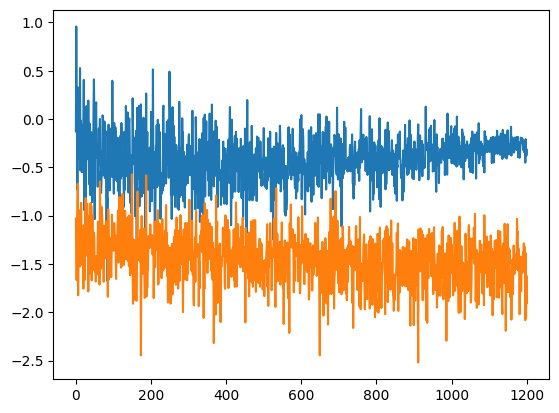

In [ ]:
# Plot Losses

plt.plot(train_data[0], label='Generator Loss')
plt.plot(train_data[1], label="Discriminator Loss")
plt.set_title("Generator vs Discriminator Loss")
plt.set_xlabel('Epochs')
plt.set_ylabel('Loss')
plt.legend()
plt.show()